In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import io
import matplotlib.image as mpimg
from tqdm import tqdm

In [11]:
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [12]:
image_Prot = mpimg.imread(f'Draws/Prot.png')

image_MP = mpimg.imread(f'Draws/{0}.png')

random_list = [15, 28, 23, 16, 18, 12, 9, 22, 10, 24, 25, 13, 21, 4, 5, 2, 11, 29, 27, 8, 6, 3, 7, 19, 30, 17, 26, 20, 1, 14]

  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\pedro220068\AppData\Local\Temp\ipykernel_3360\1551089492.py:229: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(buf))  # Append the frame to the list
 95%|█████████▌| 1900/2000 [08:19<00:26,  3.80it/s]


MemoryError: Unable to allocate 1.34 MiB for an array with shape (313, 281, 4) and data type float32

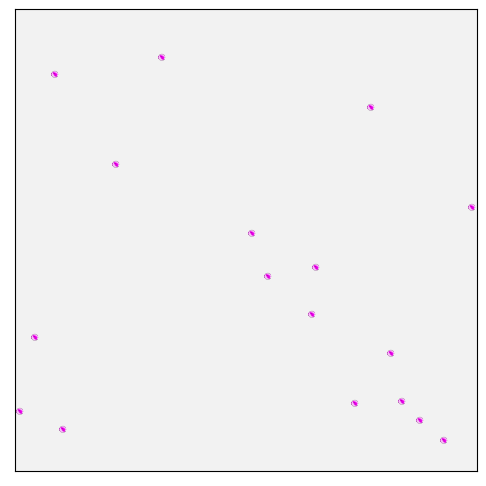

In [13]:
class Particle:
    def __init__(self, position, radius, velocity, tag):
        self.position = np.array(position, dtype=float)
        self.radius = radius
        self.velocity = np.array(velocity, dtype=float)
        self.mass = radius ** 2
        self.tag = tag
        self.aggregated = False
        if self.tag == 'MP':
            self.n_proteins = 0

    def move(self, dt):
        self.position += self.velocity * dt

    def check_collision(self, other):
        # Calculate the distance between two particles
        displacement = self.position - other.position
        distance = np.linalg.norm(displacement)
        
        # Check if they are overlapping
        if distance <= self.radius + other.radius:
            return True
        return False
    
    def check_aggregation(self, other):
        
        # Check if the particles are not already aggregated
        if not self.aggregated and not other.aggregated:

            # Check if self particle is MP
            if self.tag == 'MP':
                
                # Check if other particle is Prot
                if other.tag == 'Prot':
                    
                    # Saturation
                    if self.n_proteins < 30:
                        return True
                    
            # Check if other particle is MP
            if other.tag == 'MP':
                
                # Check if self particle is Prot
                if self.tag == 'Prot':
                    
                    # Saturation
                    if other.n_proteins < 30:
                        return True
            
        return False

    def resolve_collision(self, other):
        # Calculate displacement and distance between particles
        displacement = self.position - other.position
        distance = np.linalg.norm(displacement)

        if distance == 0:
            return  # To avoid division by zero in the next steps
        
        # Unit normal and tangential vectors
        unit_normal = displacement / distance
        unit_tangential = np.array([-unit_normal[1], unit_normal[0]])

        # Decompose velocities into radial and tangential components
        v1_radial = np.dot(self.velocity, unit_normal)
        v1_tangential = np.dot(self.velocity, unit_tangential)
        v2_radial = np.dot(other.velocity, unit_normal)
        v2_tangential = np.dot(other.velocity, unit_tangential)

        # Compute new radial velocities using conservation of momentum
        m1, m2 = self.mass, other.mass
        alpha = m1 / m2
        beta = m2 / m1
        v1_radial_new = ((1 - alpha) / (alpha + 1)) * v1_radial + (2 / (alpha + 1)) * v2_radial
        v2_radial_new = ((1 - beta) / (beta + 1)) * v2_radial + (2 / (beta + 1)) * v1_radial

        # New velocities in normal and tangential directions
        self.velocity = v1_radial_new * unit_normal + v1_tangential * unit_tangential
        other.velocity = v2_radial_new * unit_normal + v2_tangential * unit_tangential
        
    def resolve_aggregation(self, other):
        
        # Mass conservation
        aggregate_mass = self.mass + other.mass
        
        # Mass center conservation
        aggregate_position = (self.mass * self.position + other.mass * other.position)/(self.mass + other.mass)
        
        # Momentum conservation
        aggregate_velocity = (self.mass * self.velocity + other.mass * other.velocity)/(self.mass + other.mass)
        
        # Tag definition
        aggregate_tag = "MP"
        
        # What particle is the MP?
        if self.tag == "MP":
            
            # Geometric correction
            aggregate_radius = self.radius
        
            # Creating the particle
            aggregate = Particle(aggregate_position, aggregate_radius, aggregate_velocity, aggregate_tag)
            
            # Correcting the mass and n_proteins
            aggregate.mass = aggregate_mass
            
            # Updating the number of aggregated proteins
            aggregate.n_proteins = self.n_proteins + 1
        
        if other.tag == "MP":
            
            # Geometric correction
            aggregate_radius = other.radius
        
            # Creating the particle
            aggregate = Particle(aggregate_position, aggregate_radius, aggregate_velocity, aggregate_tag)
            
            # Correcting the mass and n_proteins
            aggregate.mass = aggregate_mass
            
            # Updating the number of aggregated proteins
            aggregate.n_proteins = other.n_proteins + 1
            
        return aggregate
        

# Initialize particles randomly in a 2D space
def initialize_particles(num_particles, space_size, particles_radius, particles_tag):
    particles = []
    occupied_positions = np.zeros((space_size, space_size))
    
    for i in range(len(num_particles)):
        for _ in range(num_particles[i]):
            radius = particles_radius[i]
            placed = False
    
            while not placed:
                x, y = np.random.randint(radius, space_size-radius, size=2)
    
                # Check if the space around the particle is free
                if np.all(occupied_positions[int(x-radius):int(x+radius), int(y-radius):int(y+radius)] == 0):
                    velocity = np.random.uniform(-1, 1, size=2)
                    particle = Particle([x, y], radius, velocity, particles_tag[i])
                    particles.append(particle)
                    
                    # Mark space as occupied
                    occupied_positions[int(x-radius):int(x+radius), int(y-radius):int(y+radius)] = 1
                    placed = True

    return particles

# Simulate the particle motion and collision
def simulate(particles, dt, num_steps, space_size):
    for step in tqdm(range(num_steps)):
        new_particles = particles.copy()
        for i, particle in enumerate(particles):
            particle.move(dt)
            
            # Check for boundary collisions (assuming elastic walls)
            if particle.position[0] - particle.radius < 0 or particle.position[0] + particle.radius > space_size:
                particle.velocity[0] *= -1
            if particle.position[1] - particle.radius < 0 or particle.position[1] + particle.radius > space_size:
                particle.velocity[1] *= -1

            # Check for particle-particle collisions
            for j in range(i + 1, len(particles)):
                if particle.check_collision(particles[j]):
                    
                    # Check if particles will aggregate
                    if particle.check_aggregation(particles[j]):

                        # Create the aggregate
                        aggregate = particle.resolve_aggregation(particles[j])
                        
                        # Change particles list
                        new_particles.remove(particle)
                        new_particles.remove(particles[j])
                        new_particles.append(aggregate)
                        
                        # Correcting the double aggregation
                        particle.aggregated = True
                        particles[j].aggregated = True
                        
                    else:
                        particle.resolve_collision(particles[j])
        
        particles = new_particles.copy()

        # Visualize the system after each step
        if step%25 == 0:
            visualize_system(particles, space_size, step)
        
    return particles

# Visualize particles
def visualize_system(particles, space_size, step):
    plt.figure(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    plt.gca().set_facecolor('#f2f2f2')
    # plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)
    plt.xticks([])
    plt.yticks([])

    for particle in particles:
        particle_extent = create_image_extent(particle.position, particle.radius)
        if particle.tag == "Prot":
            circle = plt.imshow(image_Prot, extent = particle_extent)
        else:
            proteins_number = particle.n_proteins
            circle = plt.imshow(image_MP, extent = particle_extent)
            plt.gca().add_artist(circle)
            for i in range(proteins_number):
                protein_extent = create_image_extent_corona(particle.position, random_list[i], particle.radius, 1)
                circle = plt.imshow(image_Prot, extent = protein_extent)
                plt.gca().add_artist(circle)
        
    
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.rcParams['axes.facecolor'] = 'black'
    plt.tight_layout()

    # Save the frame to a BytesIO object instead of a file
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100)
    buf.seek(0)
    frames.append(imageio.imread(buf))  # Append the frame to the list
    plt.close()  # Close the figure to free up memory
    
    
def create_image_extent(position, size_p):
    left = position[0] - size_p
    right = position[0] + size_p
    bottom = position[1] - size_p
    up = position[1] + size_p
    return (left, right, bottom, up)

def create_image_extent_corona(position_MP, i, size_mp, size_p):
    theta = i * (2*np.pi/30)
    R = size_mp + size_p
    position = position_MP + np.array([R*np.cos(theta), R*np.sin(theta)])
    left = position[0] - size_p
    right = position[0] + size_p
    bottom = position[1] - size_p
    up = position[1] + size_p
    return (left, right, bottom, up)


# Main parameters
num_particles = [2, 120]
space_size = 100
particles_radius = [10, 1]
particles_tag = ['MP', 'Prot']
dt = 0.1
num_steps = 2000

# Create a list to store frames in memory
frames = []

# Initialize particles and run simulation
particles = initialize_particles(num_particles, space_size, particles_radius, particles_tag)
particles = simulate(particles, dt, num_steps, space_size)
# Create a GIF from the frames in memory
imageio.mimsave('corona_formation.gif', frames, duration=0.1)

In [4]:
for particle in particles:
    if particle.tag == "MP":
        print(particle.n_proteins)

30
30


[]

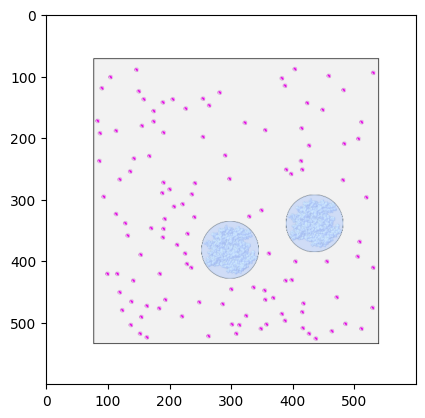

In [5]:
plt.imshow(frames[1])
plt.plot()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import io
import matplotlib.image as mpimg
from tqdm import tqdm

image_Prot = mpimg.imread(f'Draws/Prot.png')
image_MP = mpimg.imread(f'Draws/{0}.png')

class Particle:
    def __init__(self, position, radius, velocity, tag):
        self.position = np.array(position, dtype=float)
        self.radius = radius
        self.velocity = np.array(velocity, dtype=float)
        self.mass = radius ** 2
        self.tag = tag
        self.aggregated = False
        if self.tag == 'MP':
            self.n_proteins = 0

    def move(self, dt):
        self.position += self.velocity * dt

    def check_collision(self, other):
        displacement = self.position - other.position
        distance = np.linalg.norm(displacement)
        if distance <= self.radius + other.radius:
            return True
        return False

    def check_aggregation(self, other):
        if not self.aggregated and not other.aggregated:
            if self.tag == 'MP' and other.tag == 'Prot':
                # if self.n_proteins < 30:  # Limite de proteínas agregadas
                if 1 - (self.n_proteins+1)/30 > np.random.random():
                    return True
            if self.tag == 'Prot' and other.tag == 'MP':
                # if other.n_proteins < 30:
                if 1 - (other.n_proteins+1)/30 > np.random.random():
                    return True
        return False

    def resolve_aggregation(self, other):
        aggregate_mass = self.mass + other.mass
        aggregate_position = (self.mass * self.position + other.mass * other.position) / aggregate_mass
        aggregate_velocity = (self.mass * self.velocity + other.mass * other.velocity) / aggregate_mass
        if self.tag == "MP":
            aggregate_radius = self.radius + 0.025  # Aumentar o raio da MP ao agregar
            aggregate = Particle(aggregate_position, aggregate_radius, aggregate_velocity, "MP")
            aggregate.n_proteins = self.n_proteins + 1
        else:
            aggregate_radius = other.radius + 0.025
            aggregate = Particle(aggregate_position, aggregate_radius, aggregate_velocity, "MP")
            aggregate.n_proteins = other.n_proteins + 1
        return aggregate

def initialize_particles(num_particles, space_size, particles_radius, particles_tag):
    particles = []
    for i in range(len(num_particles)):
        for _ in range(num_particles[i]):
            radius = particles_radius[i]
            placed = False
            while not placed:
                x, y = np.random.randint(radius, space_size-radius, size=2)
                velocity = np.random.uniform(-1, 1, size=2)
                particle = Particle([x, y], radius, velocity, particles_tag[i])
                particles.append(particle)
                placed = True
    return particles

def simulate(particles, dt, num_steps, space_size):
    # for step in tqdm(range(num_steps)):
    for step in range(num_steps):
        new_particles = particles.copy()
        for i, particle in enumerate(particles):
            particle.move(dt)
            if particle.position[0] - particle.radius < 0 or particle.position[0] + particle.radius > space_size:
                particle.velocity[0] *= -1
            if particle.position[1] - particle.radius < 0 or particle.position[1] + particle.radius > space_size:
                particle.velocity[1] *= -1
            for j in range(i + 1, len(particles)):
                if particle.check_collision(particles[j]):
                    if particle.check_aggregation(particles[j]):
                        aggregate = particle.resolve_aggregation(particles[j])
                        new_particles.remove(particle)
                        new_particles.remove(particles[j])
                        new_particles.append(aggregate)
                        particle.aggregated = True
                        particles[j].aggregated = True
        particles = new_particles.copy()
    return particles

mean_radius_sims,std_radius_sims = [],[]

for _ in tqdm(range(3)):

    concentrations = np.linspace(0,250,12,dtype='int')
    mp_radius_mean,mp_radius_std = [],[]

    for protein_count in concentrations:
        
        num_particles = [2, protein_count]
        space_size = 100
        particles_radius = [10, 1]
        particles_tag = ['MP', 'Prot']
        dt = 0.1
        num_steps = 1000
        
        # print(f"Simulando com {protein_count} proteínas.")
        
        particles = initialize_particles(num_particles, space_size, particles_radius, particles_tag)
        particles = simulate(particles, dt, num_steps, space_size)
        
        radius = []
        for particle in particles:
            if particle.tag == 'MP':
                total_radius = particle.radius + (2*1*particle.n_proteins)/30
                radius.append(total_radius)
                # print(f"Raio hidrodinâmico da MP: {total_radius}")
                radius.append(total_radius)
        
        mp_radius_mean.append(np.mean(radius))
        mp_radius_std.append(np.std(radius))
    
    mean_radius_sims.append(mp_radius_mean)
    std_radius_sims.append(mp_radius_std)

100%|██████████| 3/3 [33:39<00:00, 673.11s/it]


In [10]:
# plt.errorbar(concentrations,mp_radius_mean,yerr=mp_radius_std)
# plt.plot(concentrations,mp_radius_mean)

dic_i = {}
for i in range(len(mean_radius_sims[0])):
    dic_i[i] = []

for i in range(3):
    for m_i,m in enumerate(mean_radius_sims[i]):
        dic_i[m_i].append(m)
#         if i not in dic_i:
#             dic_i[i] = [mean_radius_sims[i][c_i]]
#         else:
#             dic_i[i].append(mean_radius_sims[i][c_i])

In [61]:
final_values,final_values_std = [],[]
for k in dic_i.keys():
    final_values.append(10*np.mean(dic_i[k]))
    final_values_std.append(10*np.std(dic_i[k]))
    # plt.errorbar(concentrations[k],np.mean(dic_i[k]),yerr=np.std(dic_i[k]),color='black',capsize=2)

In [183]:
final_values_c = []
for i in final_values:
    prots = (i-100)/0.025
    final_values_c.append(prots*0.005+100)

In [192]:
final_values_std_c = []
for i in final_values_std:
    scale_factor = 0.005 / 0.025
    new_std = i * scale_factor
    final_values_std_c.append(new_std)

In [197]:
c_ul = []
for concentration in concentrations:
    c_ul.append(convert_uL(concentration))

In [204]:
conc = np.linspace(20,120,len(final_values_c))

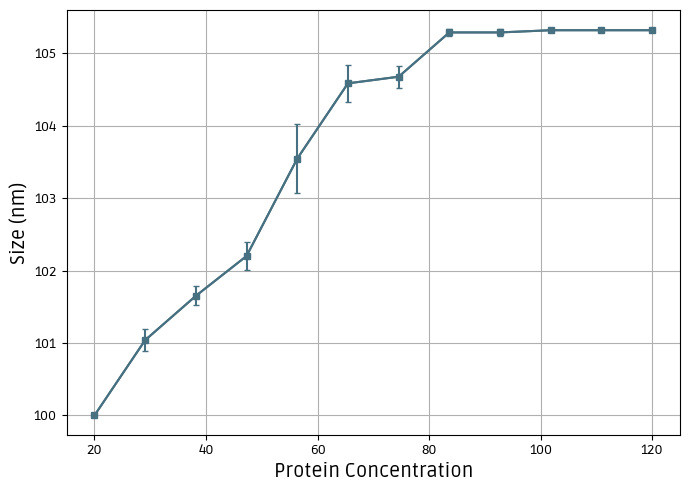

In [209]:
plt.figure(figsize=(7,5))
# plt.errorbar(concentrations,final_values,yerr=final_values_std,capsize=2,color='#477081')
plt.errorbar(conc,final_values_c,yerr=final_values_std_c,capsize=2,color='#477081')

# plt.plot(concentrations,final_values,color='#477081',marker='s',markersize=4)
plt.plot(conc,final_values_c,color='#477081',marker='s',markersize=4)

plt.xlabel('Protein Concentration',fontsize=14)
plt.ylabel('Size (nm)',fontsize=14)
# plt.xlim(0,250)
# plt.ylim(10,13)
# plt.xticks([])

plt.grid()
plt.tight_layout()
plt.savefig('curve.svg',dpi=800,transparent=True)

#### Analytical Model

In [1]:
# lambda = \langle v_{\rel} \rangle (r_{Prot} + r_{MP})^2 \frac{1}{1 + e^{\beta (\epsilon - \alpha)}} \Delta t
# $ R_{Total} = R_{MP} + 2 R_{Prot} (1 - e^{\frac{\lambda}{n_{max}} [\text{Prot}]}) $

v_media = 2
r_prot = 1.25e-9
r_mp = 5e-8
beta = -0.44
epsilon = 1e10
alpha = -0.44
deltaT = 1
N_max = 1600

def r_total(p_conc):
    lam = - v_media * (r_prot + r_mp)**2 * 1/(1+np.exp(-beta*(epsilon-alpha))) * deltaT
    # print(lam)
    return r_mp + 2*r_prot * (1-np.exp(p_conc*lam/N_max))

In [2]:
protein_mw = 44880000 # g/mol
massa_proteina = 7.45e-17 * 1e+3 # mg/num_prot
conc_prot = 1 # mg/ml

def convert_uL(uL):
    volume_total = (uL + 600)*1e-3 # uL
    massa_total = uL*conc_prot*1e-3 # mg
    c_atual_prot = massa_total/volume_total # mg/ml
    return (c_atual_prot/massa_proteina) * 1e6 # num_prot/m^3

In [6]:
r_t_vals = []
for i in np.linspace(0,100,122):
    c_atual_prot = convert_uL(i)
    r_t_vals.append(1e9*2*r_total(c_atual_prot))

C:\Users\pedro220068\AppData\Local\Temp\ipykernel_3360\4035711243.py:14: RuntimeWarning: overflow encountered in exp
  lam = - v_media * (r_prot + r_mp)**2 * 1/(1+np.exp(-beta*(epsilon-alpha))) * deltaT


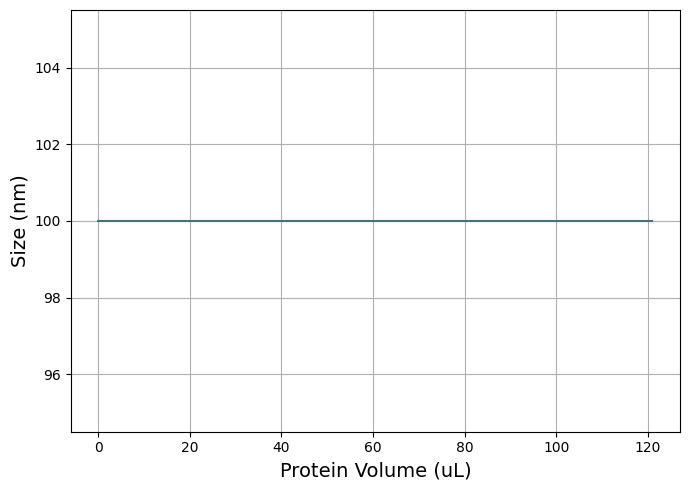

In [8]:
plt.figure(figsize=(7,5))

plt.plot(range(len(r_t_vals)),r_t_vals,color='#477081')
plt.xlabel('Protein Volume (uL)',fontsize=14)
plt.ylabel('Size (nm)',fontsize=14)

# plt.xlim(0,120)
# plt.ylim(100,105)
plt.grid()
plt.tight_layout()

# plt.savefig('analytical_curve.svg',dpi=600,transparent=True)